Quantile 0.25
2014 comp: 46.5	2014 life: 209.0
	Command set: SELECT `idx`, `idx_paper`, `content`, `video_visual`, `publishedAt`, `duration`, `channelId`, `viewCount`, `likeCount`, `dislikeCount`, `commentCount`, `favoriteCount`, `liveStreaming` FROM `scopus_videos_2014_life`
	Current list_where_clauses: ['`viewCount`>209']
	Current list_where_clauses: ['`viewCount`>209', "`content`='paper_reference'"]
	sql: SELECT `idx`, `idx_paper`, `content`, `video_visual`, `publishedAt`, `duration`, `channelId`, `viewCount`, `likeCount`, `dislikeCount`, `commentCount`, `favoriteCount`, `liveStreaming` FROM `scopus_videos_2014_life` WHERE (`viewCount`>209 AND `content`='paper_reference');
	Command set: SELECT `idx`, `channelId`, `subscriberCount` FROM `channels`
	Current list_where_clauses: ['`subscriberCount` IS NOT NULL']
	sql: SELECT `idx`, `channelId`, `subscriberCount` FROM `channels` WHERE (`subscriberCount` IS NOT NULL);
[+]Processing 1 of 56 videos
[+]Processing 2 of 56 videos
[+]Processing

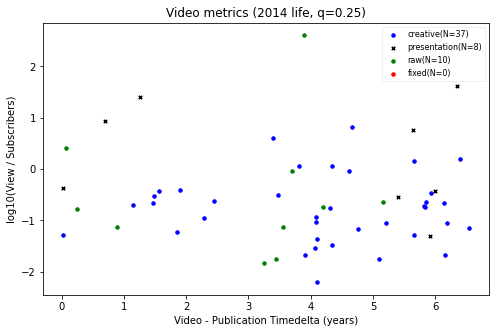

In [1]:
# Reference를 스타일별로 플롯
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from db_handler import DBHandler
from datetime import date
%matplotlib inline

db_handler = DBHandler()
_list_fields = [
"idx",
"idx_paper",
"content",
"video_visual",
"publishedAt",
"duration",
"channelId",
"viewCount",
"likeCount",
"dislikeCount",
"commentCount",
"favoriteCount",
"liveStreaming"
]
_list_videos = list()

# Calc quantile
_q = .25
_q_2014_comp = pd.read_csv("scopus/scopus_videos_2014_comp.csv", header=0)["viewCount"].quantile(_q)
_q_2014_life = pd.read_csv("scopus/scopus_videos_2014_life.csv", header=0)["viewCount"].quantile(_q)
print("Quantile %.2f\n2014 comp: %.1f\t2014 life: %.1f" % (_q, _q_2014_comp, _q_2014_life))

# 2014 comp
# db_handler.sql_handler.select(
# "scopus_videos_2014_comp",
# _list_fields
# # ).where("viewCount", 1000, ">").where("content", "paper_reference")
# ).where("viewCount", _q_2014_comp, ">").where("content", "paper_reference")
# _list_videos += db_handler.execute().fetchall()

# 2014 life
db_handler.sql_handler.select(
"scopus_videos_2014_life",
_list_fields
# ).where("viewCount", 1000, ">").where("content", "paper_reference")
).where("viewCount", _q_2014_life, ">").where("content", "paper_reference")
_list_videos += db_handler.execute().fetchall()

_list_dict_videos = list(
map(lambda _row: dict(zip(_list_fields, _row)), _list_videos))

# Channels : Get subscriber count
db_handler.sql_handler.select(
"channels",
["idx", "channelId", "subscriberCount"]
).where("subscriberCount", None, "<>")  # Filter NULL subscriberCount
_list_channels = db_handler.execute().fetchall()
# {channelId : tuple(...), ...}
_dict_channels = dict(
zip(list(map(lambda _row: _row[1], _list_channels)), _list_channels))

# Hashmap
dict_content_key = dict()
dict_content_key["creative"] = "creative"
dict_content_key["presentation"] = "presentation"
dict_content_key["raw"] = "raw"
dict_content_key["fixed"] = "fixed"
dict_x = dict()
dict_x["creative"] = list()
dict_x["presentation"] = list()
dict_x["raw"] = list()
dict_x["fixed"] = list()
dict_y = dict()
dict_y["creative"] = list()
dict_y["presentation"] = list()
dict_y["raw"] = list()
dict_y["fixed"] = list()

df1 = pd.read_csv("scopus/scopus_math+comp_top5perc_1401-1406.csv", header=0)
df2 = pd.read_csv("scopus/scopus_life+earch_top60_1401-1406.csv", header=0)
df = pd.concat([df1, df2])

for _i, _dict_row in enumerate(_list_dict_videos):
    print("[+]Processing %d of %d videos" % (_i+1, len(_list_dict_videos)))
    # Calc age
    _date_video = _dict_row["publishedAt"].date()
    _scopus_row = df[df["DOI"] == _dict_row["idx_paper"]]
    if len(_scopus_row) > 1:
        _scopus_row = _scopus_row.iloc[0]
    _date_paper = date(_scopus_row["Year"], _scopus_row["Month"], 1)
    _age = (_date_video - _date_paper).days/365
    _dict_row["age"] = _age

    # Age - Scaled View
    # Calc view/subscriber
#     _dict_row["scaled_view"] = _dict_row["viewCount"] / _dict_channels[_dict_row["channelId"]][2] if _dict_channels[_dict_row["channelId"]][2] != 0 else _dict_row["viewCount"]
    try:
        _dict_row["scaled_view"] = np.log10(_dict_row["viewCount"] / _dict_channels[_dict_row["channelId"]][2]) if _dict_channels[_dict_row["channelId"]][2] != 0 else np.log10(_dict_row["viewCount"])
        dict_y[dict_content_key[_dict_row["video_visual"]]].append(_dict_row["scaled_view"])
    except KeyError:
        continue

    # Age - Scaled Like
    # Calc like/subscriber
    # _dict_row["scaled_like"] = _dict_row["likeCount"] / _dict_channels[_dict_row["channelId"]
    #                                                                    ][2] if _dict_channels[_dict_row["channelId"]][2] != 0 else _dict_row["likeCount"]
    # dict_y[dict_content_key[_dict_row["video_visual"]]]].append(
    #     _dict_row["scaled_like"])

    # Age - View
#     dict_y[dict_content_key[_dict_row["video_visual"]]].append(_dict_row["viewCount"])
#     dict_y[dict_content_key[_dict_row["video_visual"]]].append(np.log10(_dict_row["viewCount"]))

    # Age - Like
    # dict_y[dict_content_key[_dict_row["video_visual"]]]].append(
    #     _dict_row["likeCount"])

    # Boxplot: like/dislike
    # if _dict_row["likeCount"] in (None, 0) or _dict_row["dislikeCount"] == None:
    #     continue
    # _dict_row["r_like_dislike"] = _dict_row["likeCount"] / _dict_row["dislikeCount"] if _dict_row["dislikeCount"] != 0 else _dict_row["likeCount"]
    # dict_y[dict_content_key[_dict_row["video_visual"]]]].append(_dict_row["r_like_dislike"])

    # Add x
    dict_x[dict_content_key[_dict_row["video_visual"]]].append(_dict_row["age"])

# Scatter
plt.figure(figsize=(8, 5))

# exp = plt.scatter(x=dict_x["paper_explanation"],
#             y=dict_y["paper_explanation"], s=12, marker="o", color="blue")
# ref = plt.scatter(x=dict_x["paper_reference"],
#             y=dict_y["paper_reference"], s=12, marker="x", color="black")
# sup = plt.scatter(x=dict_x["paper_supplementary"],
#             y=dict_y["paper_supplementary"], s=12, marker="o", color="green")
# ass = plt.scatter(x=dict_x["paper_assessment"],
#             y=dict_y["paper_assessment"], s=12, marker="o", color="red")
# news = plt.scatter(x=dict_x["news"],
#             y=dict_y["news"], s=12, marker="o", color="lightblue")

# plt.legend((ref, sup, news, exp, ass),
#     (
#         "paper_reference(N=%d)" % len(dict_y["paper_reference"]),
#         "paper_supplementary(N=%d)" % len(dict_y["paper_supplementary"]),
#         "news(N=%d)" % len(dict_y["news"]),
#         "paper_explanation(N=%d)" % len(dict_y["paper_explanation"]),
#         "paper_assessment(N=%d)" % len(dict_y["paper_assessment"]),
#     ),
#     scatterpoints=1,
#     loc='upper right',
#     fontsize=8)

cre = plt.scatter(x=dict_x["creative"],
            y=dict_y["creative"], s=12, marker="o", color="blue")
pre = plt.scatter(x=dict_x["presentation"],
            y=dict_y["presentation"], s=12, marker="x", color="black")
raw = plt.scatter(x=dict_x["raw"],
            y=dict_y["raw"], s=12, marker="o", color="green")
fix = plt.scatter(x=dict_x["fixed"],
            y=dict_y["fixed"], s=12, marker="o", color="red")

plt.legend((cre, pre, raw, fix),
    (
        "creative(N=%d)" % len(dict_y["creative"]),
        "presentation(N=%d)" % len(dict_y["presentation"]),
        "raw(N=%d)" % len(dict_y["raw"]),
        "fixed(N=%d)" % len(dict_y["fixed"]),
    ),
    scatterpoints=1,
    loc='upper right',
    fontsize=8,
    framealpha=0.3)

# xs = dict_x["paper_explanation"] + dict_x["paper_reference"] + \
#     dict_x["paper_supplementary"] + dict_x["paper_assessment"]
# ys = dict_y["paper_explanation"] + dict_y["paper_reference"] + \
#     dict_y["paper_supplementary"] + dict_y["paper_assessment"]
# cs = ["blue"] * len(dict_y["paper_explanation"]) + ["black"] * len(dict_y["paper_reference"]) + \
#     ["green"] * len(dict_y["paper_supplementary"]) + \
#     ["red"] * len(dict_y["paper_assessment"])
# plt.scatter(x=xs, y=ys, s=10, c=cs)

plt.title("Video metrics (2014 life, q=%.2f)" % _q)
plt.xlabel("Video - Publication Timedelta (years)")
plt.ylabel("log10(View / Subscribers)")
# plt.yscale("log")
# plt.ylim(1, 100000)
plt.show()

2014 life: presentation은 기울기가 큰 경향, raw는 작은 경향.

creative는 presentation과 raw를 합친 경향. presentation 경향 비디오 수가 적으니, 그쪽을 리뷰해보면 뭔가 특징을 알수도. e.g. presentation스러운 creative

Quantile 0.25
2014 comp: 46.5	2014 life: 209.0
	Command set: SELECT `idx`, `idx_paper`, `content`, `video_visual`, `publishedAt`, `duration`, `channelId`, `viewCount`, `likeCount`, `dislikeCount`, `commentCount`, `favoriteCount`, `liveStreaming` FROM `scopus_videos_2014_comp`
	Current list_where_clauses: ['`viewCount`>46']
	Current list_where_clauses: ['`viewCount`>46', "`content`='paper_reference'"]
	sql: SELECT `idx`, `idx_paper`, `content`, `video_visual`, `publishedAt`, `duration`, `channelId`, `viewCount`, `likeCount`, `dislikeCount`, `commentCount`, `favoriteCount`, `liveStreaming` FROM `scopus_videos_2014_comp` WHERE (`viewCount`>46 AND `content`='paper_reference');
	Command set: SELECT `idx`, `channelId`, `subscriberCount` FROM `channels`
	sql: SELECT `idx`, `channelId`, `subscriberCount` FROM `channels`;


/home/hweem/git/mastersdegree/ytcrawl/ytcrawl0/lib/python3.5/site-packages/ipykernel_launcher.py:80: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



[+]Processing 1 of 67 videos
[+]Processing 2 of 67 videos
[+]Processing 3 of 67 videos
[+]Processing 4 of 67 videos
[+]Processing 5 of 67 videos
[+]Processing 6 of 67 videos
[+]Processing 7 of 67 videos
[+]Processing 8 of 67 videos
[+]Processing 9 of 67 videos
[+]Processing 10 of 67 videos
[+]Processing 11 of 67 videos
[+]Processing 12 of 67 videos
[+]Processing 13 of 67 videos
[+]Processing 14 of 67 videos
[+]Processing 15 of 67 videos
[+]Processing 16 of 67 videos
[+]Processing 17 of 67 videos
[+]Processing 18 of 67 videos
[+]Processing 19 of 67 videos
[+]Processing 20 of 67 videos
[+]Processing 21 of 67 videos
[+]Processing 22 of 67 videos
[+]Processing 23 of 67 videos
[+]Processing 24 of 67 videos
[+]Processing 25 of 67 videos
[+]Processing 26 of 67 videos
[+]Processing 27 of 67 videos
[+]Processing 28 of 67 videos
[+]Processing 29 of 67 videos
[+]Processing 30 of 67 videos
[+]Processing 31 of 67 videos
[+]Processing 32 of 67 videos
[+]Processing 33 of 67 videos
[+]Processing 34 of

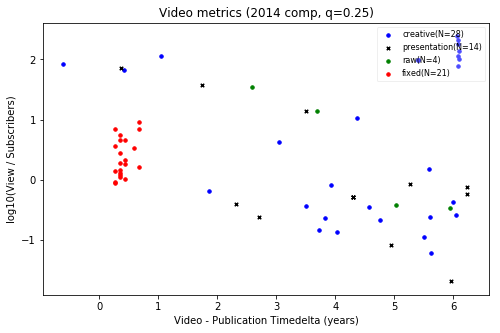

In [25]:
# Reference를 스타일별로 플롯
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from db_handler import DBHandler
from datetime import date
%matplotlib inline

db_handler = DBHandler()
_list_fields = [
"idx",
"idx_paper",
"content",
"video_visual",
"publishedAt",
"duration",
"channelId",
"viewCount",
"likeCount",
"dislikeCount",
"commentCount",
"favoriteCount",
"liveStreaming"
]
_list_videos = list()

# Calc quantile
_q = .25
_q_2014_comp = pd.read_csv("scopus/scopus_videos_2014_comp.csv", header=0)["viewCount"].quantile(_q)
_q_2014_life = pd.read_csv("scopus/scopus_videos_2014_life.csv", header=0)["viewCount"].quantile(_q)
print("Quantile %.2f\n2014 comp: %.1f\t2014 life: %.1f" % (_q, _q_2014_comp, _q_2014_life))

# 2014 comp
db_handler.sql_handler.select(
"scopus_videos_2014_comp",
_list_fields
# ).where("viewCount", 1000, ">").where("content", "paper_reference")
).where("viewCount", _q_2014_comp, ">").where("content", "paper_reference")
_list_videos += db_handler.execute().fetchall()

# 2014 life
# db_handler.sql_handler.select(
# "scopus_videos_2014_life",
# _list_fields
# # ).where("viewCount", 1000, ">").where("content", "paper_reference")
# ).where("viewCount", _q_2014_life, ">").where("content", "paper_reference")
# _list_videos += db_handler.execute().fetchall()

_list_dict_videos = list(
map(lambda _row: dict(zip(_list_fields, _row)), _list_videos))

# Channels : Get subscriber count
db_handler.sql_handler.select(
"channels",
["idx", "channelId", "subscriberCount"]
)
_list_channels = db_handler.execute().fetchall()
# {channelId : tuple(...), ...}
_dict_channels = dict(
zip(list(map(lambda _row: _row[1], _list_channels)), _list_channels))

# Hashmap
dict_content_key = dict()
dict_content_key["creative"] = "creative"
dict_content_key["presentation"] = "presentation"
dict_content_key["raw"] = "raw"
dict_content_key["fixed"] = "fixed"
dict_x = dict()
dict_x["creative"] = list()
dict_x["presentation"] = list()
dict_x["raw"] = list()
dict_x["fixed"] = list()
dict_y = dict()
dict_y["creative"] = list()
dict_y["presentation"] = list()
dict_y["raw"] = list()
dict_y["fixed"] = list()

df1 = pd.read_csv("scopus/scopus_math+comp_top5perc_1401-1406.csv", header=0)
df2 = pd.read_csv("scopus/scopus_life+earch_top60_1401-1406.csv", header=0)
df = pd.concat([df1, df2])

for _i, _dict_row in enumerate(_list_dict_videos):
    print("[+]Processing %d of %d videos" % (_i+1, len(_list_dict_videos)))
    # Calc age
    _date_video = _dict_row["publishedAt"].date()
    _scopus_row = df[df["DOI"] == _dict_row["idx_paper"]]
    if len(_scopus_row) > 1:
        _scopus_row = _scopus_row.iloc[0]
    _date_paper = date(_scopus_row["Year"], _scopus_row["Month"], 1)
    _age = (_date_video - _date_paper).days/365
    _dict_row["age"] = _age

    # Age - Scaled View
    # Calc view/subscriber
#     _dict_row["scaled_view"] = _dict_row["viewCount"] / _dict_channels[_dict_row["channelId"]][2] if _dict_channels[_dict_row["channelId"]][2] != 0 else _dict_row["viewCount"]
    _dict_row["scaled_view"] = np.log10(_dict_row["viewCount"] / _dict_channels[_dict_row["channelId"]][2]) if _dict_channels[_dict_row["channelId"]][2] != 0 else np.log10(_dict_row["viewCount"])
    dict_y[dict_content_key[_dict_row["video_visual"]]].append(_dict_row["scaled_view"])

    # Age - Scaled Like
    # Calc like/subscriber
    # _dict_row["scaled_like"] = _dict_row["likeCount"] / _dict_channels[_dict_row["channelId"]
    #                                                                    ][2] if _dict_channels[_dict_row["channelId"]][2] != 0 else _dict_row["likeCount"]
    # dict_y[dict_content_key[_dict_row["video_visual"]]]].append(
    #     _dict_row["scaled_like"])

    # Age - View
#     dict_y[dict_content_key[_dict_row["video_visual"]]].append(_dict_row["viewCount"])
#     dict_y[dict_content_key[_dict_row["video_visual"]]].append(np.log10(_dict_row["viewCount"]))

    # Age - Like
    # dict_y[dict_content_key[_dict_row["video_visual"]]]].append(
    #     _dict_row["likeCount"])

    # Boxplot: like/dislike
    # if _dict_row["likeCount"] in (None, 0) or _dict_row["dislikeCount"] == None:
    #     continue
    # _dict_row["r_like_dislike"] = _dict_row["likeCount"] / _dict_row["dislikeCount"] if _dict_row["dislikeCount"] != 0 else _dict_row["likeCount"]
    # dict_y[dict_content_key[_dict_row["video_visual"]]]].append(_dict_row["r_like_dislike"])

    # Add x
    dict_x[dict_content_key[_dict_row["video_visual"]]].append(_dict_row["age"])

# Scatter
plt.figure(figsize=(8, 5))

# exp = plt.scatter(x=dict_x["paper_explanation"],
#             y=dict_y["paper_explanation"], s=12, marker="o", color="blue")
# ref = plt.scatter(x=dict_x["paper_reference"],
#             y=dict_y["paper_reference"], s=12, marker="x", color="black")
# sup = plt.scatter(x=dict_x["paper_supplementary"],
#             y=dict_y["paper_supplementary"], s=12, marker="o", color="green")
# ass = plt.scatter(x=dict_x["paper_assessment"],
#             y=dict_y["paper_assessment"], s=12, marker="o", color="red")
# news = plt.scatter(x=dict_x["news"],
#             y=dict_y["news"], s=12, marker="o", color="lightblue")

# plt.legend((ref, sup, news, exp, ass),
#     (
#         "paper_reference(N=%d)" % len(dict_y["paper_reference"]),
#         "paper_supplementary(N=%d)" % len(dict_y["paper_supplementary"]),
#         "news(N=%d)" % len(dict_y["news"]),
#         "paper_explanation(N=%d)" % len(dict_y["paper_explanation"]),
#         "paper_assessment(N=%d)" % len(dict_y["paper_assessment"]),
#     ),
#     scatterpoints=1,
#     loc='upper right',
#     fontsize=8)

cre = plt.scatter(x=dict_x["creative"],
            y=dict_y["creative"], s=12, marker="o", color="blue")
pre = plt.scatter(x=dict_x["presentation"],
            y=dict_y["presentation"], s=12, marker="x", color="black")
raw = plt.scatter(x=dict_x["raw"],
            y=dict_y["raw"], s=12, marker="o", color="green")
fix = plt.scatter(x=dict_x["fixed"],
            y=dict_y["fixed"], s=12, marker="o", color="red")

plt.legend((cre, pre, raw, fix),
    (
        "creative(N=%d)" % len(dict_y["creative"]),
        "presentation(N=%d)" % len(dict_y["presentation"]),
        "raw(N=%d)" % len(dict_y["raw"]),
        "fixed(N=%d)" % len(dict_y["fixed"]),
    ),
    scatterpoints=1,
    loc='upper right',
    fontsize=8,
    framealpha=0.3)

# xs = dict_x["paper_explanation"] + dict_x["paper_reference"] + \
#     dict_x["paper_supplementary"] + dict_x["paper_assessment"]
# ys = dict_y["paper_explanation"] + dict_y["paper_reference"] + \
#     dict_y["paper_supplementary"] + dict_y["paper_assessment"]
# cs = ["blue"] * len(dict_y["paper_explanation"]) + ["black"] * len(dict_y["paper_reference"]) + \
#     ["green"] * len(dict_y["paper_supplementary"]) + \
#     ["red"] * len(dict_y["paper_assessment"])
# plt.scatter(x=xs, y=ys, s=10, c=cs)

plt.title("Video metrics (2014 comp, q=%.2f)" % _q)
plt.xlabel("Video - Publication Timedelta (years)")
plt.ylabel("log10(View / Subscribers)")
# plt.yscale("log")
# plt.ylim(1, 100000)
plt.show()

presentation, creative 둘 다 기울기가 큰 편. raw 샘플이 너무 적은데?(fixed때문에?)

Quantile 0.01
2014 comp: 6.8	2014 life: 8.0
	Command set: SELECT `idx`, `idx_paper`, `content`, `video_visual`, `publishedAt`, `duration`, `channelId`, `viewCount`, `likeCount`, `dislikeCount`, `commentCount`, `favoriteCount`, `liveStreaming` FROM `scopus_videos_2014_comp`
	Current list_where_clauses: ['`viewCount`>6']
	Current list_where_clauses: ['`viewCount`>6', "`content`='paper_reference'"]
	sql: SELECT `idx`, `idx_paper`, `content`, `video_visual`, `publishedAt`, `duration`, `channelId`, `viewCount`, `likeCount`, `dislikeCount`, `commentCount`, `favoriteCount`, `liveStreaming` FROM `scopus_videos_2014_comp` WHERE (`viewCount`>6 AND `content`='paper_reference');
	Command set: SELECT `idx`, `channelId`, `subscriberCount` FROM `channels`
	sql: SELECT `idx`, `channelId`, `subscriberCount` FROM `channels`;


/home/hweem/git/mastersdegree/ytcrawl/ytcrawl0/lib/python3.5/site-packages/ipykernel_launcher.py:80: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



[+]Processing 1 of 98 videos
[+]Processing 2 of 98 videos
[+]Processing 3 of 98 videos
[+]Processing 4 of 98 videos
[+]Processing 5 of 98 videos
[+]Processing 6 of 98 videos
[+]Processing 7 of 98 videos
[+]Processing 8 of 98 videos
[+]Processing 9 of 98 videos
[+]Processing 10 of 98 videos
[+]Processing 11 of 98 videos
[+]Processing 12 of 98 videos
[+]Processing 13 of 98 videos
[+]Processing 14 of 98 videos
[+]Processing 15 of 98 videos
[+]Processing 16 of 98 videos
[+]Processing 17 of 98 videos
[+]Processing 18 of 98 videos
[+]Processing 19 of 98 videos
[+]Processing 20 of 98 videos
[+]Processing 21 of 98 videos
[+]Processing 22 of 98 videos
[+]Processing 23 of 98 videos
[+]Processing 24 of 98 videos
[+]Processing 25 of 98 videos
[+]Processing 26 of 98 videos
[+]Processing 27 of 98 videos
[+]Processing 28 of 98 videos
[+]Processing 29 of 98 videos
[+]Processing 30 of 98 videos
[+]Processing 31 of 98 videos
[+]Processing 32 of 98 videos
[+]Processing 33 of 98 videos
[+]Processing 34 of

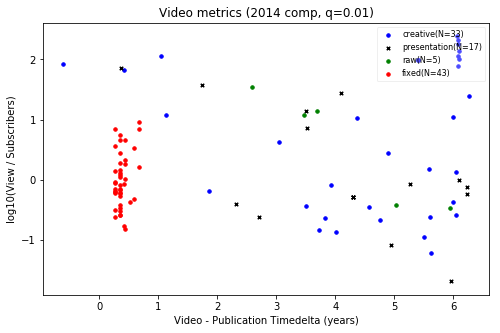

In [26]:
# Reference를 스타일별로 플롯
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from db_handler import DBHandler
from datetime import date
%matplotlib inline

db_handler = DBHandler()
_list_fields = [
"idx",
"idx_paper",
"content",
"video_visual",
"publishedAt",
"duration",
"channelId",
"viewCount",
"likeCount",
"dislikeCount",
"commentCount",
"favoriteCount",
"liveStreaming"
]
_list_videos = list()

# Calc quantile
_q = .01
_q_2014_comp = pd.read_csv("scopus/scopus_videos_2014_comp.csv", header=0)["viewCount"].quantile(_q)
_q_2014_life = pd.read_csv("scopus/scopus_videos_2014_life.csv", header=0)["viewCount"].quantile(_q)
print("Quantile %.2f\n2014 comp: %.1f\t2014 life: %.1f" % (_q, _q_2014_comp, _q_2014_life))

# 2014 comp
db_handler.sql_handler.select(
"scopus_videos_2014_comp",
_list_fields
# ).where("viewCount", 1000, ">").where("content", "paper_reference")
).where("viewCount", _q_2014_comp, ">").where("content", "paper_reference")
_list_videos += db_handler.execute().fetchall()

# 2014 life
# db_handler.sql_handler.select(
# "scopus_videos_2014_life",
# _list_fields
# # ).where("viewCount", 1000, ">").where("content", "paper_reference")
# ).where("viewCount", _q_2014_life, ">").where("content", "paper_reference")
# _list_videos += db_handler.execute().fetchall()

_list_dict_videos = list(
map(lambda _row: dict(zip(_list_fields, _row)), _list_videos))

# Channels : Get subscriber count
db_handler.sql_handler.select(
"channels",
["idx", "channelId", "subscriberCount"]
)
_list_channels = db_handler.execute().fetchall()
# {channelId : tuple(...), ...}
_dict_channels = dict(
zip(list(map(lambda _row: _row[1], _list_channels)), _list_channels))

# Hashmap
dict_content_key = dict()
dict_content_key["creative"] = "creative"
dict_content_key["presentation"] = "presentation"
dict_content_key["raw"] = "raw"
dict_content_key["fixed"] = "fixed"
dict_x = dict()
dict_x["creative"] = list()
dict_x["presentation"] = list()
dict_x["raw"] = list()
dict_x["fixed"] = list()
dict_y = dict()
dict_y["creative"] = list()
dict_y["presentation"] = list()
dict_y["raw"] = list()
dict_y["fixed"] = list()

df1 = pd.read_csv("scopus/scopus_math+comp_top5perc_1401-1406.csv", header=0)
df2 = pd.read_csv("scopus/scopus_life+earch_top60_1401-1406.csv", header=0)
df = pd.concat([df1, df2])

for _i, _dict_row in enumerate(_list_dict_videos):
    print("[+]Processing %d of %d videos" % (_i+1, len(_list_dict_videos)))
    # Calc age
    _date_video = _dict_row["publishedAt"].date()
    _scopus_row = df[df["DOI"] == _dict_row["idx_paper"]]
    if len(_scopus_row) > 1:
        _scopus_row = _scopus_row.iloc[0]
    _date_paper = date(_scopus_row["Year"], _scopus_row["Month"], 1)
    _age = (_date_video - _date_paper).days/365
    _dict_row["age"] = _age

    # Age - Scaled View
    # Calc view/subscriber
#     _dict_row["scaled_view"] = _dict_row["viewCount"] / _dict_channels[_dict_row["channelId"]][2] if _dict_channels[_dict_row["channelId"]][2] != 0 else _dict_row["viewCount"]
    _dict_row["scaled_view"] = np.log10(_dict_row["viewCount"] / _dict_channels[_dict_row["channelId"]][2]) if _dict_channels[_dict_row["channelId"]][2] != 0 else np.log10(_dict_row["viewCount"])
    dict_y[dict_content_key[_dict_row["video_visual"]]].append(_dict_row["scaled_view"])

    # Age - Scaled Like
    # Calc like/subscriber
    # _dict_row["scaled_like"] = _dict_row["likeCount"] / _dict_channels[_dict_row["channelId"]
    #                                                                    ][2] if _dict_channels[_dict_row["channelId"]][2] != 0 else _dict_row["likeCount"]
    # dict_y[dict_content_key[_dict_row["video_visual"]]]].append(
    #     _dict_row["scaled_like"])

    # Age - View
#     dict_y[dict_content_key[_dict_row["video_visual"]]].append(_dict_row["viewCount"])
#     dict_y[dict_content_key[_dict_row["video_visual"]]].append(np.log10(_dict_row["viewCount"]))

    # Age - Like
    # dict_y[dict_content_key[_dict_row["video_visual"]]]].append(
    #     _dict_row["likeCount"])

    # Boxplot: like/dislike
    # if _dict_row["likeCount"] in (None, 0) or _dict_row["dislikeCount"] == None:
    #     continue
    # _dict_row["r_like_dislike"] = _dict_row["likeCount"] / _dict_row["dislikeCount"] if _dict_row["dislikeCount"] != 0 else _dict_row["likeCount"]
    # dict_y[dict_content_key[_dict_row["video_visual"]]]].append(_dict_row["r_like_dislike"])

    # Add x
    dict_x[dict_content_key[_dict_row["video_visual"]]].append(_dict_row["age"])

# Scatter
plt.figure(figsize=(8, 5))

# exp = plt.scatter(x=dict_x["paper_explanation"],
#             y=dict_y["paper_explanation"], s=12, marker="o", color="blue")
# ref = plt.scatter(x=dict_x["paper_reference"],
#             y=dict_y["paper_reference"], s=12, marker="x", color="black")
# sup = plt.scatter(x=dict_x["paper_supplementary"],
#             y=dict_y["paper_supplementary"], s=12, marker="o", color="green")
# ass = plt.scatter(x=dict_x["paper_assessment"],
#             y=dict_y["paper_assessment"], s=12, marker="o", color="red")
# news = plt.scatter(x=dict_x["news"],
#             y=dict_y["news"], s=12, marker="o", color="lightblue")

# plt.legend((ref, sup, news, exp, ass),
#     (
#         "paper_reference(N=%d)" % len(dict_y["paper_reference"]),
#         "paper_supplementary(N=%d)" % len(dict_y["paper_supplementary"]),
#         "news(N=%d)" % len(dict_y["news"]),
#         "paper_explanation(N=%d)" % len(dict_y["paper_explanation"]),
#         "paper_assessment(N=%d)" % len(dict_y["paper_assessment"]),
#     ),
#     scatterpoints=1,
#     loc='upper right',
#     fontsize=8)

cre = plt.scatter(x=dict_x["creative"],
            y=dict_y["creative"], s=12, marker="o", color="blue")
pre = plt.scatter(x=dict_x["presentation"],
            y=dict_y["presentation"], s=12, marker="x", color="black")
raw = plt.scatter(x=dict_x["raw"],
            y=dict_y["raw"], s=12, marker="o", color="green")
fix = plt.scatter(x=dict_x["fixed"],
            y=dict_y["fixed"], s=12, marker="o", color="red")

plt.legend((cre, pre, raw, fix),
    (
        "creative(N=%d)" % len(dict_y["creative"]),
        "presentation(N=%d)" % len(dict_y["presentation"]),
        "raw(N=%d)" % len(dict_y["raw"]),
        "fixed(N=%d)" % len(dict_y["fixed"]),
    ),
    scatterpoints=1,
    loc='upper right',
    fontsize=8,
    framealpha=0.3)

# xs = dict_x["paper_explanation"] + dict_x["paper_reference"] + \
#     dict_x["paper_supplementary"] + dict_x["paper_assessment"]
# ys = dict_y["paper_explanation"] + dict_y["paper_reference"] + \
#     dict_y["paper_supplementary"] + dict_y["paper_assessment"]
# cs = ["blue"] * len(dict_y["paper_explanation"]) + ["black"] * len(dict_y["paper_reference"]) + \
#     ["green"] * len(dict_y["paper_supplementary"]) + \
#     ["red"] * len(dict_y["paper_assessment"])
# plt.scatter(x=xs, y=ys, s=10, c=cs)

plt.title("Video metrics (2014 comp, q=%.2f)" % _q)
plt.xlabel("Video - Publication Timedelta (years)")
plt.ylabel("log10(View / Subscribers)")
# plt.yscale("log")
# plt.ylim(1, 100000)
plt.show()

2014 comp의 raw비디오는 원래 적었다.

2014 comp, life reference video둘 다에 대해서: presentation은 다른 스타일에 비해 기울기가 크다. <- 회귀분석으로 기울기 재도 될듯

-> reference video는 프레젠테이션 형식이 가장 수요/인기가 좋다?